In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy
from tqdm import tqdm
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [35]:
#hyper params
num_epoch = 40
cuda_device = 0
batch_size = 14
hidden_dim=256
input_dim=28*28
out_dim=10
device = f'cuda:{cuda_device}' if cuda_device != -1 else 'cpu'

In [36]:
def collate_fn(data):
    pics = []
    target = []
    for item in data:

        pics.append(numpy.array(item[0]))
        target.append(item[1])
    return {
        'data': torch.from_numpy(numpy.array(pics)).float() / 255,
        'target': torch.from_numpy(numpy.array(target)).type(torch.LongTensor),
    }

In [37]:
#model
class FC_model(nn.Module):
    def __init__(self,
                 input_dim:int,
                 hidden_dim:int,
                 out_dim:int,
                 ):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, out_dim)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        return self.activation(self.linear3(x))

In [38]:
model = FC_model(input_dim, hidden_dim, out_dim)
model.train()
model.to(device)

FC_model(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=10, bias=True)
  (activation): ReLU()
)

In [39]:
#optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [40]:
dataset = datasets.MNIST('.', download=True)

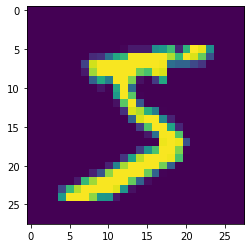

In [41]:
import matplotlib.pyplot as plt
plt.imshow(dataset.data[0].detach().numpy())
plt.show()

In [42]:

#loss
loss_func = nn.CrossEntropyLoss()

In [43]:
loss_fc = []
for epoch in tqdm(range(20)):
    dataloader = DataLoader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    for step, batch in enumerate(dataloader):
        data = batch['data'].to(device).view(batch['data'].size(0), -1)
        optim.zero_grad()
        predict = model(data)
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        loss_fc.append(loss.item())

100%|██████████| 20/20 [03:05<00:00,  9.26s/it]


In [44]:
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [45]:
model_cnn = CNN_model()
model_cnn.train()
model_cnn.to(device)

CNN_model(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [46]:
#optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

#loss
loss_func = nn.CrossEntropyLoss()

In [47]:
data_mnist = datasets.MNIST('/files/',
                      train=True,
                      download=True,
                      transform=torchvision.transforms.Compose([
                          torchvision.transforms.ToTensor(),
                      ]))

In [48]:
losses_cnn = []
for epoch in tqdm(range(20)):
    dataloader = DataLoader(
        dataset=data_mnist,
        # collate_fn=collate_fn,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    for step, (data, target) in enumerate(dataloader):
        optim.zero_grad()
        predict = model_cnn(data.to(device))
        loss = loss_func(predict, target.to(device))
        loss.backward()
        optim.step()
        losses_cnn.append(loss.item())

100%|██████████| 20/20 [04:57<00:00, 14.88s/it]


In [49]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(20)), y=losses_cnn, name='CNN'))
fig.add_trace(go.Scatter(x=list(range(20)), y=loss_fc, name='FC'))